<h1 align="center">INET4061 Project</h1>
<h1 align="center">Facial Recognition: identifying name and expression</h1>
<h3 align="center">Ruoyun Chen, Yangjiawen Xu</h3>
<h3 align="center">Nov 30, 2018</h3>

## Overview

In this project, we use the labled face in the wild to identify the name and use the JAFFE dataset and labeled face in the wild to facial expression recognition.

The fist task of face recognition in this project is identifying a person from an image of the person's face. This can be treated as a classification problem where we assign the person's name to an image of a face.

To identify the name,
- Preprocessing data with PCA
- Train a SVM model
- Hyper-parameters tuning using a Cross-Validated Grid Search
- Plot the images on test set
- Evaluation

The second task of face recognition is to identify a person's emotions.This can also be treated as a classification problem where we assign the person's emotion to an image of a face. 

To identify the emotions,
- Preprocess data 
- Use representational autoencoder units to classify an image among one of the seven different emotions
- Create CNN Layer Set
- Train on the JAFFE dataset
- Test on the labeled faces in the wild dataset
- Evaluation

Reference:
+ https://github.com/orlandopython/ML-Workshop/blob/09af4cf135a77b5397f3ea532ddf8d2b3950b46a/Eigen%20Faces.ipynb
+ http://nbviewer.jupyter.org/github/ogrisel/notebooks/blob/master/Labeled%20Faces%20in%20the%20Wild%20recognition.ipynb
+ https://github.com/pckuo/hands_on_ML/blob/bb07420d5f3e6686157ed3ea683d5dffbc6cf281/exercise/ex07_application_to_face_recognition.ipynb
+ 
https://github.com/ashishpatel26/Facial-Expression-Recognization-using-JAFFE
+ 
https://github.com/ashishpatel26/Facial-Expression-Recognization-using-JAFFE
+ 
https://github.com/nicolascerna/emotion-recognition-example

Data Source:
+ http://vis-www.cs.umass.edu/lfw/#information
+ http://www.kasrl.org/jaffe.html

In [1]:
%pylab inline

import pylab as pl
import numpy as np
import os,cv2
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from pylab import rcParams
rcParams['figure.figsize'] = 20, 10

from sklearn.utils import shuffle
from sklearn.cross_validation import train_test_split

import warnings
warnings.filterwarnings('ignore')


Populating the interactive namespace from numpy and matplotlib


/Applications/anaconda3/lib/python3.6/site-packages/sklearn/cross_validation.py:41: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


## Data
Labeled Faces in the Wild is a database of face photographs designed for studying the problem of unconstrained face recognition. The data set contains more than 13,000 images of faces collected from the web. Each face has been labeled with the name of the person pictured. 1680 of the people pictured have two or more distinct photos in the data set. The only constraint on these faces is that they were detected by the Viola-Jones face detector. More details can be found in http://vis-www.cs.umass.edu/lfw.

We use a subset of this dataset to identify face.

Here is the data of Labeled Faces in the Wild. 

In [2]:
from sklearn import datasets
lfw_people = datasets.fetch_lfw_people(min_faces_per_person=70, resize=0.4,
                                       data_home='datasets')
lfw_people.data.shape


(1288, 1850)

In [3]:

!ls datasets

lfw_home


In [4]:

X = lfw_people.data
y = lfw_people.target
names = lfw_people.target_names

n_samples, n_features = X.shape
_, h, w = lfw_people.images.shape
n_classes = len(names)

print("n_samples: {}".format(n_samples))
print("n_features: {}".format(n_features))
print("n_classes: {}".format(n_classes))

n_samples: 1288
n_features: 1850
n_classes: 7


visualize these faces 

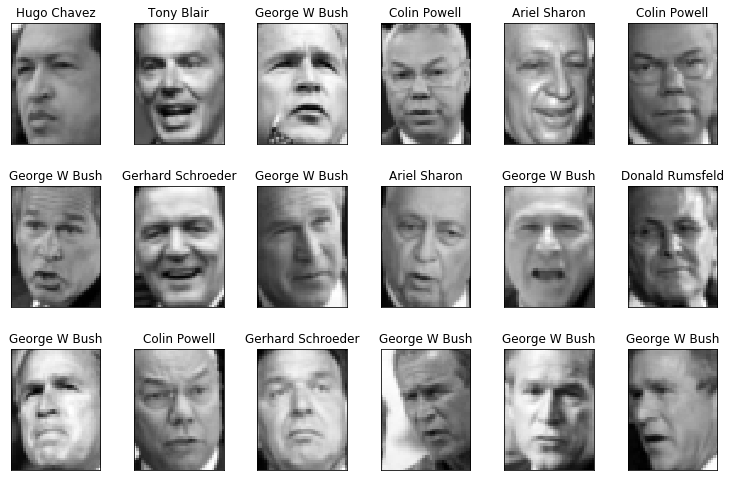

In [5]:
def plot_gallery(images, titles, h, w, n_row=3, n_col=6):
    """Helper function to plot a gallery of portraits"""
    pl.figure(figsize=(1.7 * n_col, 2.3 * n_row))
    pl.subplots_adjust(bottom=0, left=.01, right=.99, top=.90, hspace=.35)
    for i in range(n_row * n_col):
        pl.subplot(n_row, n_col, i + 1)
        pl.imshow(images[i].reshape((h, w)), cmap=pl.cm.gray)
        pl.title(titles[i], size=12)
        pl.xticks(())
        pl.yticks(())

plot_gallery(X, names[y], h, w)

JAFFE is the database which contains 213 images of 7 facial expressions (6 basic facial expressions + 1 neutral) posed by 10 Japanese female models. Each image has been rated on 6 emotion adjectives by 60 Japanese subjects. More details can be found in http://www.kasrl.org/jaffe.html.

Here is the data of JAFFE.

In [6]:
#Define Datapath
data_path = './jaffe/'
data_dir_list = os.listdir(data_path)

img_rows=256
img_cols=256
num_channel=1

num_epoch=10

img_data_list=[]


for dataset in data_dir_list:
    img_list=os.listdir(data_path+'/'+ dataset)
    print ('Loaded the images of dataset-'+'{}\n'.format(dataset))
    for img in img_list:
        input_img=cv2.imread(data_path + '/'+ dataset + '/'+ img )
        input_img=cv2.cvtColor(input_img, cv2.COLOR_BGR2GRAY)
        input_img_resize=cv2.resize(input_img,(128,128))
        img_data_list.append(input_img_resize)
        
img_data = np.array(img_data_list)
img_data = img_data.astype('float32')
img_data = img_data/255
img_data.shape

FileNotFoundError: [Errno 2] No such file or directory: './jaffe/'

## Exploratory Data Analysis

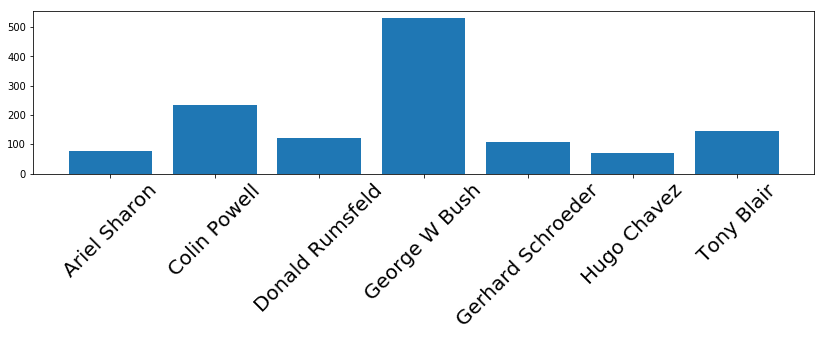

In [7]:

pl.figure(figsize=(14, 3))

y_unique = np.unique(y)
counts = [(y == i).sum() for i in y_unique]

pl.xticks(y_unique,  names[y_unique])
locs, labels = pl.xticks()
pl.setp(labels, rotation=45, size=20)
_ = pl.bar(y_unique, counts)

We'll do a typical train-test split on the images to make this happen:

In [9]:
from sklearn.cross_validation import train_test_split
X_train, X_test, y_train, y_test = train_test_split(lfw_people.data, lfw_people.target, random_state=0)

print(X_train.shape, X_test.shape)


(966, 1850) (322, 1850)


1850 dimensions is a lot for SVM. We can use PCA to reduce these 1850 features to a manageable size, while maintaining most of the information in the dataset. Here it is useful to use a variant of PCA called RandomizedPCA, which is an approximation of PCA that can be much faster for large datasets. The interface is the same as the normal PCA we saw earlier:

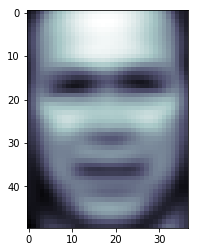

In [11]:
from sklearn import decomposition
pca = decomposition.RandomizedPCA(n_components=150, whiten=True)
pca.fit(X_train)

plt.imshow(pca.mean_.reshape((50, 37)), cmap=plt.cm.bone)

One interesting part of PCA is that it computes the "mean" face.
The principal components measure deviations about this mean along orthogonal axes. It is also interesting to visualize these principal components:

In [13]:
print(pca.components_.shape)

(150, 1850)


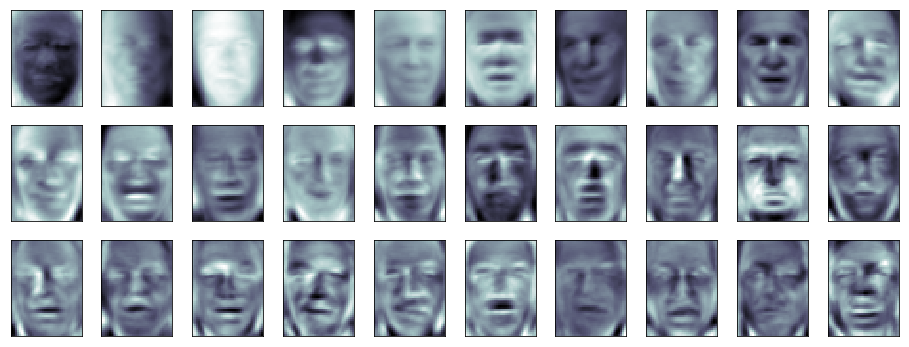

In [14]:
fig = plt.figure(figsize=(16, 6))
for i in range(30):
    ax = fig.add_subplot(3, 10, i + 1, xticks=[], yticks=[])
    ax.imshow(pca.components_[i].reshape((50, 37)), cmap=plt.cm.bone)

The components ("eigenfaces") are ordered by their importance from top-left to bottom-right. We see that the first few components seem to primarily take care of lighting conditions; the remaining components pull out certain identifying features: the nose, eyes, eyebrows, etc.

With this projection computed, we can now project our original training and test data onto the PCA basis:

In [16]:
X_train_pca = pca.transform(X_train)
X_test_pca = pca.transform(X_test)
print(X_train_pca.shape)
print(X_test_pca.shape)

(966, 150)
(322, 150)



These projected components correspond to factors in a linear combination of component images such that the combination approaches the original face.

## Models
### Training a Gaussian Kernel SVM
We'll perform support-vector-machine classification on this reduced dataset:

In [38]:
from sklearn.svm import SVC

svm = SVC(kernel='rbf', class_weight='auto')

svm

SVC(C=1.0, cache_size=200, class_weight='auto', coef0=0.0,
  decision_function_shape='ovr', degree=3, gamma='auto', kernel='rbf',
  max_iter=-1, probability=False, random_state=None, shrinking=True,
  tol=0.001, verbose=False)

In [47]:
from sklearn.cross_validation import StratifiedShuffleSplit
from sklearn.cross_validation import cross_val_score
    
cv = StratifiedShuffleSplit(y_train, test_size=0.20, n_iter=3)
svm_cv_scores = cross_val_score(svm, X_train_pca, y_train, scoring='f1', n_jobs=2)
#svm_cv_scores

JoblibValueError: JoblibValueError
___________________________________________________________________________
Multiprocessing exception:
...........................................................................
/Applications/anaconda3/lib/python3.6/runpy.py in _run_module_as_main(mod_name='ipykernel_launcher', alter_argv=1)
    188         sys.exit(msg)
    189     main_globals = sys.modules["__main__"].__dict__
    190     if alter_argv:
    191         sys.argv[0] = mod_spec.origin
    192     return _run_code(code, main_globals, None,
--> 193                      "__main__", mod_spec)
        mod_spec = ModuleSpec(name='ipykernel_launcher', loader=<_f...b/python3.6/site-packages/ipykernel_launcher.py')
    194 
    195 def run_module(mod_name, init_globals=None,
    196                run_name=None, alter_sys=False):
    197     """Execute a module's code without importing it

...........................................................................
/Applications/anaconda3/lib/python3.6/runpy.py in _run_code(code=<code object <module> at 0x10d7366f0, file "/App...3.6/site-packages/ipykernel_launcher.py", line 5>, run_globals={'__annotations__': {}, '__builtins__': <module 'builtins' (built-in)>, '__cached__': '/Applications/anaconda3/lib/python3.6/site-packages/__pycache__/ipykernel_launcher.cpython-36.pyc', '__doc__': 'Entry point for launching an IPython kernel.\n\nTh...orts until\nafter removing the cwd from sys.path.\n', '__file__': '/Applications/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py', '__loader__': <_frozen_importlib_external.SourceFileLoader object>, '__name__': '__main__', '__package__': '', '__spec__': ModuleSpec(name='ipykernel_launcher', loader=<_f...b/python3.6/site-packages/ipykernel_launcher.py'), 'app': <module 'ipykernel.kernelapp' from '/Application.../python3.6/site-packages/ipykernel/kernelapp.py'>, ...}, init_globals=None, mod_name='__main__', mod_spec=ModuleSpec(name='ipykernel_launcher', loader=<_f...b/python3.6/site-packages/ipykernel_launcher.py'), pkg_name='', script_name=None)
     80                        __cached__ = cached,
     81                        __doc__ = None,
     82                        __loader__ = loader,
     83                        __package__ = pkg_name,
     84                        __spec__ = mod_spec)
---> 85     exec(code, run_globals)
        code = <code object <module> at 0x10d7366f0, file "/App...3.6/site-packages/ipykernel_launcher.py", line 5>
        run_globals = {'__annotations__': {}, '__builtins__': <module 'builtins' (built-in)>, '__cached__': '/Applications/anaconda3/lib/python3.6/site-packages/__pycache__/ipykernel_launcher.cpython-36.pyc', '__doc__': 'Entry point for launching an IPython kernel.\n\nTh...orts until\nafter removing the cwd from sys.path.\n', '__file__': '/Applications/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py', '__loader__': <_frozen_importlib_external.SourceFileLoader object>, '__name__': '__main__', '__package__': '', '__spec__': ModuleSpec(name='ipykernel_launcher', loader=<_f...b/python3.6/site-packages/ipykernel_launcher.py'), 'app': <module 'ipykernel.kernelapp' from '/Application.../python3.6/site-packages/ipykernel/kernelapp.py'>, ...}
     86     return run_globals
     87 
     88 def _run_module_code(code, init_globals=None,
     89                     mod_name=None, mod_spec=None,

...........................................................................
/Applications/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py in <module>()
     11     # This is added back by InteractiveShellApp.init_path()
     12     if sys.path[0] == '':
     13         del sys.path[0]
     14 
     15     from ipykernel import kernelapp as app
---> 16     app.launch_new_instance()

...........................................................................
/Applications/anaconda3/lib/python3.6/site-packages/traitlets/config/application.py in launch_instance(cls=<class 'ipykernel.kernelapp.IPKernelApp'>, argv=None, **kwargs={})
    653 
    654         If a global instance already exists, this reinitializes and starts it
    655         """
    656         app = cls.instance(**kwargs)
    657         app.initialize(argv)
--> 658         app.start()
        app.start = <bound method IPKernelApp.start of <ipykernel.kernelapp.IPKernelApp object>>
    659 
    660 #-----------------------------------------------------------------------------
    661 # utility functions, for convenience
    662 #-----------------------------------------------------------------------------

...........................................................................
/Applications/anaconda3/lib/python3.6/site-packages/ipykernel/kernelapp.py in start(self=<ipykernel.kernelapp.IPKernelApp object>)
    481         if self.poller is not None:
    482             self.poller.start()
    483         self.kernel.start()
    484         self.io_loop = ioloop.IOLoop.current()
    485         try:
--> 486             self.io_loop.start()
        self.io_loop.start = <bound method BaseAsyncIOLoop.start of <tornado.platform.asyncio.AsyncIOMainLoop object>>
    487         except KeyboardInterrupt:
    488             pass
    489 
    490 launch_new_instance = IPKernelApp.launch_instance

...........................................................................
/Applications/anaconda3/lib/python3.6/site-packages/tornado/platform/asyncio.py in start(self=<tornado.platform.asyncio.AsyncIOMainLoop object>)
    122         except (RuntimeError, AssertionError):
    123             old_loop = None
    124         try:
    125             self._setup_logging()
    126             asyncio.set_event_loop(self.asyncio_loop)
--> 127             self.asyncio_loop.run_forever()
        self.asyncio_loop.run_forever = <bound method BaseEventLoop.run_forever of <_Uni...EventLoop running=True closed=False debug=False>>
    128         finally:
    129             asyncio.set_event_loop(old_loop)
    130 
    131     def stop(self):

...........................................................................
/Applications/anaconda3/lib/python3.6/asyncio/base_events.py in run_forever(self=<_UnixSelectorEventLoop running=True closed=False debug=False>)
    417             sys.set_asyncgen_hooks(firstiter=self._asyncgen_firstiter_hook,
    418                                    finalizer=self._asyncgen_finalizer_hook)
    419         try:
    420             events._set_running_loop(self)
    421             while True:
--> 422                 self._run_once()
        self._run_once = <bound method BaseEventLoop._run_once of <_UnixS...EventLoop running=True closed=False debug=False>>
    423                 if self._stopping:
    424                     break
    425         finally:
    426             self._stopping = False

...........................................................................
/Applications/anaconda3/lib/python3.6/asyncio/base_events.py in _run_once(self=<_UnixSelectorEventLoop running=True closed=False debug=False>)
   1427                         logger.warning('Executing %s took %.3f seconds',
   1428                                        _format_handle(handle), dt)
   1429                 finally:
   1430                     self._current_handle = None
   1431             else:
-> 1432                 handle._run()
        handle._run = <bound method Handle._run of <Handle BaseAsyncIOLoop._handle_events(15, 1)>>
   1433         handle = None  # Needed to break cycles when an exception occurs.
   1434 
   1435     def _set_coroutine_wrapper(self, enabled):
   1436         try:

...........................................................................
/Applications/anaconda3/lib/python3.6/asyncio/events.py in _run(self=<Handle BaseAsyncIOLoop._handle_events(15, 1)>)
    140             self._callback = None
    141             self._args = None
    142 
    143     def _run(self):
    144         try:
--> 145             self._callback(*self._args)
        self._callback = <bound method BaseAsyncIOLoop._handle_events of <tornado.platform.asyncio.AsyncIOMainLoop object>>
        self._args = (15, 1)
    146         except Exception as exc:
    147             cb = _format_callback_source(self._callback, self._args)
    148             msg = 'Exception in callback {}'.format(cb)
    149             context = {

...........................................................................
/Applications/anaconda3/lib/python3.6/site-packages/tornado/platform/asyncio.py in _handle_events(self=<tornado.platform.asyncio.AsyncIOMainLoop object>, fd=15, events=1)
    112             self.writers.remove(fd)
    113         del self.handlers[fd]
    114 
    115     def _handle_events(self, fd, events):
    116         fileobj, handler_func = self.handlers[fd]
--> 117         handler_func(fileobj, events)
        handler_func = <function wrap.<locals>.null_wrapper>
        fileobj = <zmq.sugar.socket.Socket object>
        events = 1
    118 
    119     def start(self):
    120         try:
    121             old_loop = asyncio.get_event_loop()

...........................................................................
/Applications/anaconda3/lib/python3.6/site-packages/tornado/stack_context.py in null_wrapper(*args=(<zmq.sugar.socket.Socket object>, 1), **kwargs={})
    271         # Fast path when there are no active contexts.
    272         def null_wrapper(*args, **kwargs):
    273             try:
    274                 current_state = _state.contexts
    275                 _state.contexts = cap_contexts[0]
--> 276                 return fn(*args, **kwargs)
        args = (<zmq.sugar.socket.Socket object>, 1)
        kwargs = {}
    277             finally:
    278                 _state.contexts = current_state
    279         null_wrapper._wrapped = True
    280         return null_wrapper

...........................................................................
/Applications/anaconda3/lib/python3.6/site-packages/zmq/eventloop/zmqstream.py in _handle_events(self=<zmq.eventloop.zmqstream.ZMQStream object>, fd=<zmq.sugar.socket.Socket object>, events=1)
    445             return
    446         zmq_events = self.socket.EVENTS
    447         try:
    448             # dispatch events:
    449             if zmq_events & zmq.POLLIN and self.receiving():
--> 450                 self._handle_recv()
        self._handle_recv = <bound method ZMQStream._handle_recv of <zmq.eventloop.zmqstream.ZMQStream object>>
    451                 if not self.socket:
    452                     return
    453             if zmq_events & zmq.POLLOUT and self.sending():
    454                 self._handle_send()

...........................................................................
/Applications/anaconda3/lib/python3.6/site-packages/zmq/eventloop/zmqstream.py in _handle_recv(self=<zmq.eventloop.zmqstream.ZMQStream object>)
    475             else:
    476                 raise
    477         else:
    478             if self._recv_callback:
    479                 callback = self._recv_callback
--> 480                 self._run_callback(callback, msg)
        self._run_callback = <bound method ZMQStream._run_callback of <zmq.eventloop.zmqstream.ZMQStream object>>
        callback = <function wrap.<locals>.null_wrapper>
        msg = [<zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>]
    481         
    482 
    483     def _handle_send(self):
    484         """Handle a send event."""

...........................................................................
/Applications/anaconda3/lib/python3.6/site-packages/zmq/eventloop/zmqstream.py in _run_callback(self=<zmq.eventloop.zmqstream.ZMQStream object>, callback=<function wrap.<locals>.null_wrapper>, *args=([<zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>],), **kwargs={})
    427         close our socket."""
    428         try:
    429             # Use a NullContext to ensure that all StackContexts are run
    430             # inside our blanket exception handler rather than outside.
    431             with stack_context.NullContext():
--> 432                 callback(*args, **kwargs)
        callback = <function wrap.<locals>.null_wrapper>
        args = ([<zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>],)
        kwargs = {}
    433         except:
    434             gen_log.error("Uncaught exception in ZMQStream callback",
    435                           exc_info=True)
    436             # Re-raise the exception so that IOLoop.handle_callback_exception

...........................................................................
/Applications/anaconda3/lib/python3.6/site-packages/tornado/stack_context.py in null_wrapper(*args=([<zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>],), **kwargs={})
    271         # Fast path when there are no active contexts.
    272         def null_wrapper(*args, **kwargs):
    273             try:
    274                 current_state = _state.contexts
    275                 _state.contexts = cap_contexts[0]
--> 276                 return fn(*args, **kwargs)
        args = ([<zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>],)
        kwargs = {}
    277             finally:
    278                 _state.contexts = current_state
    279         null_wrapper._wrapped = True
    280         return null_wrapper

...........................................................................
/Applications/anaconda3/lib/python3.6/site-packages/ipykernel/kernelbase.py in dispatcher(msg=[<zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>])
    278         if self.control_stream:
    279             self.control_stream.on_recv(self.dispatch_control, copy=False)
    280 
    281         def make_dispatcher(stream):
    282             def dispatcher(msg):
--> 283                 return self.dispatch_shell(stream, msg)
        msg = [<zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>]
    284             return dispatcher
    285 
    286         for s in self.shell_streams:
    287             s.on_recv(make_dispatcher(s), copy=False)

...........................................................................
/Applications/anaconda3/lib/python3.6/site-packages/ipykernel/kernelbase.py in dispatch_shell(self=<ipykernel.ipkernel.IPythonKernel object>, stream=<zmq.eventloop.zmqstream.ZMQStream object>, msg={'buffers': [], 'content': {'allow_stdin': True, 'code': "from sklearn.cross_validation import StratifiedS..., y_train, scoring='f1', n_jobs=2)\n#svm_cv_scores", 'silent': False, 'stop_on_error': True, 'store_history': True, 'user_expressions': {}}, 'header': {'date': datetime.datetime(2018, 12, 4, 1, 1, 8, 457177, tzinfo=tzutc()), 'msg_id': '66db37f077314b76950d132d51d1c431', 'msg_type': 'execute_request', 'session': '844dd7a0f3314068829813eeee0be0d5', 'username': 'username', 'version': '5.2'}, 'metadata': {}, 'msg_id': '66db37f077314b76950d132d51d1c431', 'msg_type': 'execute_request', 'parent_header': {}})
    228             self.log.warn("Unknown message type: %r", msg_type)
    229         else:
    230             self.log.debug("%s: %s", msg_type, msg)
    231             self.pre_handler_hook()
    232             try:
--> 233                 handler(stream, idents, msg)
        handler = <bound method Kernel.execute_request of <ipykernel.ipkernel.IPythonKernel object>>
        stream = <zmq.eventloop.zmqstream.ZMQStream object>
        idents = [b'844dd7a0f3314068829813eeee0be0d5']
        msg = {'buffers': [], 'content': {'allow_stdin': True, 'code': "from sklearn.cross_validation import StratifiedS..., y_train, scoring='f1', n_jobs=2)\n#svm_cv_scores", 'silent': False, 'stop_on_error': True, 'store_history': True, 'user_expressions': {}}, 'header': {'date': datetime.datetime(2018, 12, 4, 1, 1, 8, 457177, tzinfo=tzutc()), 'msg_id': '66db37f077314b76950d132d51d1c431', 'msg_type': 'execute_request', 'session': '844dd7a0f3314068829813eeee0be0d5', 'username': 'username', 'version': '5.2'}, 'metadata': {}, 'msg_id': '66db37f077314b76950d132d51d1c431', 'msg_type': 'execute_request', 'parent_header': {}}
    234             except Exception:
    235                 self.log.error("Exception in message handler:", exc_info=True)
    236             finally:
    237                 self.post_handler_hook()

...........................................................................
/Applications/anaconda3/lib/python3.6/site-packages/ipykernel/kernelbase.py in execute_request(self=<ipykernel.ipkernel.IPythonKernel object>, stream=<zmq.eventloop.zmqstream.ZMQStream object>, ident=[b'844dd7a0f3314068829813eeee0be0d5'], parent={'buffers': [], 'content': {'allow_stdin': True, 'code': "from sklearn.cross_validation import StratifiedS..., y_train, scoring='f1', n_jobs=2)\n#svm_cv_scores", 'silent': False, 'stop_on_error': True, 'store_history': True, 'user_expressions': {}}, 'header': {'date': datetime.datetime(2018, 12, 4, 1, 1, 8, 457177, tzinfo=tzutc()), 'msg_id': '66db37f077314b76950d132d51d1c431', 'msg_type': 'execute_request', 'session': '844dd7a0f3314068829813eeee0be0d5', 'username': 'username', 'version': '5.2'}, 'metadata': {}, 'msg_id': '66db37f077314b76950d132d51d1c431', 'msg_type': 'execute_request', 'parent_header': {}})
    394         if not silent:
    395             self.execution_count += 1
    396             self._publish_execute_input(code, parent, self.execution_count)
    397 
    398         reply_content = self.do_execute(code, silent, store_history,
--> 399                                         user_expressions, allow_stdin)
        user_expressions = {}
        allow_stdin = True
    400 
    401         # Flush output before sending the reply.
    402         sys.stdout.flush()
    403         sys.stderr.flush()

...........................................................................
/Applications/anaconda3/lib/python3.6/site-packages/ipykernel/ipkernel.py in do_execute(self=<ipykernel.ipkernel.IPythonKernel object>, code="from sklearn.cross_validation import StratifiedS..., y_train, scoring='f1', n_jobs=2)\n#svm_cv_scores", silent=False, store_history=True, user_expressions={}, allow_stdin=True)
    203 
    204         self._forward_input(allow_stdin)
    205 
    206         reply_content = {}
    207         try:
--> 208             res = shell.run_cell(code, store_history=store_history, silent=silent)
        res = undefined
        shell.run_cell = <bound method ZMQInteractiveShell.run_cell of <ipykernel.zmqshell.ZMQInteractiveShell object>>
        code = "from sklearn.cross_validation import StratifiedS..., y_train, scoring='f1', n_jobs=2)\n#svm_cv_scores"
        store_history = True
        silent = False
    209         finally:
    210             self._restore_input()
    211 
    212         if res.error_before_exec is not None:

...........................................................................
/Applications/anaconda3/lib/python3.6/site-packages/ipykernel/zmqshell.py in run_cell(self=<ipykernel.zmqshell.ZMQInteractiveShell object>, *args=("from sklearn.cross_validation import StratifiedS..., y_train, scoring='f1', n_jobs=2)\n#svm_cv_scores",), **kwargs={'silent': False, 'store_history': True})
    532             )
    533         self.payload_manager.write_payload(payload)
    534 
    535     def run_cell(self, *args, **kwargs):
    536         self._last_traceback = None
--> 537         return super(ZMQInteractiveShell, self).run_cell(*args, **kwargs)
        self.run_cell = <bound method ZMQInteractiveShell.run_cell of <ipykernel.zmqshell.ZMQInteractiveShell object>>
        args = ("from sklearn.cross_validation import StratifiedS..., y_train, scoring='f1', n_jobs=2)\n#svm_cv_scores",)
        kwargs = {'silent': False, 'store_history': True}
    538 
    539     def _showtraceback(self, etype, evalue, stb):
    540         # try to preserve ordering of tracebacks and print statements
    541         sys.stdout.flush()

...........................................................................
/Applications/anaconda3/lib/python3.6/site-packages/IPython/core/interactiveshell.py in run_cell(self=<ipykernel.zmqshell.ZMQInteractiveShell object>, raw_cell="from sklearn.cross_validation import StratifiedS..., y_train, scoring='f1', n_jobs=2)\n#svm_cv_scores", store_history=True, silent=False, shell_futures=True)
   2657         -------
   2658         result : :class:`ExecutionResult`
   2659         """
   2660         try:
   2661             result = self._run_cell(
-> 2662                 raw_cell, store_history, silent, shell_futures)
        raw_cell = "from sklearn.cross_validation import StratifiedS..., y_train, scoring='f1', n_jobs=2)\n#svm_cv_scores"
        store_history = True
        silent = False
        shell_futures = True
   2663         finally:
   2664             self.events.trigger('post_execute')
   2665             if not silent:
   2666                 self.events.trigger('post_run_cell', result)

...........................................................................
/Applications/anaconda3/lib/python3.6/site-packages/IPython/core/interactiveshell.py in _run_cell(self=<ipykernel.zmqshell.ZMQInteractiveShell object>, raw_cell="from sklearn.cross_validation import StratifiedS..., y_train, scoring='f1', n_jobs=2)\n#svm_cv_scores", store_history=True, silent=False, shell_futures=True)
   2780                 self.displayhook.exec_result = result
   2781 
   2782                 # Execute the user code
   2783                 interactivity = 'none' if silent else self.ast_node_interactivity
   2784                 has_raised = self.run_ast_nodes(code_ast.body, cell_name,
-> 2785                    interactivity=interactivity, compiler=compiler, result=result)
        interactivity = 'last_expr'
        compiler = <IPython.core.compilerop.CachingCompiler object>
   2786                 
   2787                 self.last_execution_succeeded = not has_raised
   2788                 self.last_execution_result = result
   2789 

...........................................................................
/Applications/anaconda3/lib/python3.6/site-packages/IPython/core/interactiveshell.py in run_ast_nodes(self=<ipykernel.zmqshell.ZMQInteractiveShell object>, nodelist=[<_ast.ImportFrom object>, <_ast.ImportFrom object>, <_ast.Assign object>, <_ast.Assign object>], cell_name='<ipython-input-47-de2ef0ec8697>', interactivity='none', compiler=<IPython.core.compilerop.CachingCompiler object>, result=<ExecutionResult object at 10eb4eeb8, execution_...rue silent=False shell_futures=True> result=None>)
   2898 
   2899         try:
   2900             for i, node in enumerate(to_run_exec):
   2901                 mod = ast.Module([node])
   2902                 code = compiler(mod, cell_name, "exec")
-> 2903                 if self.run_code(code, result):
        self.run_code = <bound method InteractiveShell.run_code of <ipykernel.zmqshell.ZMQInteractiveShell object>>
        code = <code object <module> at 0x1a1b3c16f0, file "<ipython-input-47-de2ef0ec8697>", line 5>
        result = <ExecutionResult object at 10eb4eeb8, execution_...rue silent=False shell_futures=True> result=None>
   2904                     return True
   2905 
   2906             for i, node in enumerate(to_run_interactive):
   2907                 mod = ast.Interactive([node])

...........................................................................
/Applications/anaconda3/lib/python3.6/site-packages/IPython/core/interactiveshell.py in run_code(self=<ipykernel.zmqshell.ZMQInteractiveShell object>, code_obj=<code object <module> at 0x1a1b3c16f0, file "<ipython-input-47-de2ef0ec8697>", line 5>, result=<ExecutionResult object at 10eb4eeb8, execution_...rue silent=False shell_futures=True> result=None>)
   2958         outflag = True  # happens in more places, so it's easier as default
   2959         try:
   2960             try:
   2961                 self.hooks.pre_run_code_hook()
   2962                 #rprint('Running code', repr(code_obj)) # dbg
-> 2963                 exec(code_obj, self.user_global_ns, self.user_ns)
        code_obj = <code object <module> at 0x1a1b3c16f0, file "<ipython-input-47-de2ef0ec8697>", line 5>
        self.user_global_ns = {'ALLOW_THREADS': 1, 'Annotation': <class 'matplotlib.text.Annotation'>, 'Arrow': <class 'matplotlib.patches.Arrow'>, 'Artist': <class 'matplotlib.artist.Artist'>, 'AutoLocator': <class 'matplotlib.ticker.AutoLocator'>, 'Axes': <class 'matplotlib.axes._axes.Axes'>, 'AxisError': <class 'numpy.core._internal.AxisError'>, 'BUFSIZE': 8192, 'Button': <class 'matplotlib.widgets.Button'>, 'CLIP': 0, ...}
        self.user_ns = {'ALLOW_THREADS': 1, 'Annotation': <class 'matplotlib.text.Annotation'>, 'Arrow': <class 'matplotlib.patches.Arrow'>, 'Artist': <class 'matplotlib.artist.Artist'>, 'AutoLocator': <class 'matplotlib.ticker.AutoLocator'>, 'Axes': <class 'matplotlib.axes._axes.Axes'>, 'AxisError': <class 'numpy.core._internal.AxisError'>, 'BUFSIZE': 8192, 'Button': <class 'matplotlib.widgets.Button'>, 'CLIP': 0, ...}
   2964             finally:
   2965                 # Reset our crash handler in place
   2966                 sys.excepthook = old_excepthook
   2967         except SystemExit as e:

...........................................................................
/Users/ruoyunchen/git/INET4061Project/<ipython-input-47-de2ef0ec8697> in <module>()
      1 from sklearn.cross_validation import StratifiedShuffleSplit
      2 from sklearn.cross_validation import cross_val_score
      3     
      4 cv = StratifiedShuffleSplit(y_train, test_size=0.20, n_iter=3)
----> 5 svm_cv_scores = cross_val_score(svm, X_train_pca, y_train, scoring='f1', n_jobs=2)
      6 #svm_cv_scores

...........................................................................
/Applications/anaconda3/lib/python3.6/site-packages/sklearn/cross_validation.py in cross_val_score(estimator=SVC(C=1.0, cache_size=200, class_weight='auto', ...None, shrinking=True,
  tol=0.001, verbose=False), X=array([[-0.19737591, -0.82890874, -0.47759932, ....        0.9804777 ,  0.84309185]], dtype=float32), y=array([2, 2, 3, 1, 3, 3, 6, 3, 6, 1, 3, 6, 1, 3,... 3, 3, 1, 1, 2, 1, 3, 3, 1, 4, 1, 3, 2, 1, 3, 6]), scoring='f1', cv=sklearn.cross_validation.StratifiedKFold(labels=... 6], n_folds=3, shuffle=False, random_state=None), n_jobs=2, verbose=0, fit_params=None, pre_dispatch='2*n_jobs')
   1576     parallel = Parallel(n_jobs=n_jobs, verbose=verbose,
   1577                         pre_dispatch=pre_dispatch)
   1578     scores = parallel(delayed(_fit_and_score)(clone(estimator), X, y, scorer,
   1579                                               train, test, verbose, None,
   1580                                               fit_params)
-> 1581                       for train, test in cv)
        cv = sklearn.cross_validation.StratifiedKFold(labels=... 6], n_folds=3, shuffle=False, random_state=None)
   1582     return np.array(scores)[:, 0]
   1583 
   1584 
   1585 def _fit_and_score(estimator, X, y, scorer, train, test, verbose,

...........................................................................
/Applications/anaconda3/lib/python3.6/site-packages/sklearn/externals/joblib/parallel.py in __call__(self=Parallel(n_jobs=2), iterable=<generator object cross_val_score.<locals>.<genexpr>>)
    784             if pre_dispatch == "all" or n_jobs == 1:
    785                 # The iterable was consumed all at once by the above for loop.
    786                 # No need to wait for async callbacks to trigger to
    787                 # consumption.
    788                 self._iterating = False
--> 789             self.retrieve()
        self.retrieve = <bound method Parallel.retrieve of Parallel(n_jobs=2)>
    790             # Make sure that we get a last message telling us we are done
    791             elapsed_time = time.time() - self._start_time
    792             self._print('Done %3i out of %3i | elapsed: %s finished',
    793                         (len(self._output), len(self._output),

---------------------------------------------------------------------------
Sub-process traceback:
---------------------------------------------------------------------------
ValueError                                         Mon Dec  3 19:01:08 2018
PID: 15293                 Python 3.6.5: /Applications/anaconda3/bin/python
...........................................................................
/Applications/anaconda3/lib/python3.6/site-packages/sklearn/externals/joblib/parallel.py in __call__(self=<sklearn.externals.joblib.parallel.BatchedCalls object>)
    126     def __init__(self, iterator_slice):
    127         self.items = list(iterator_slice)
    128         self._size = len(self.items)
    129 
    130     def __call__(self):
--> 131         return [func(*args, **kwargs) for func, args, kwargs in self.items]
        self.items = [(<function _fit_and_score>, (SVC(C=1.0, cache_size=200, class_weight='auto', ...None, shrinking=True,
  tol=0.001, verbose=False), array([[-0.19737591, -0.82890874, -0.47759932, ....        0.9804777 ,  0.84309185]], dtype=float32), array([2, 2, 3, 1, 3, 3, 6, 3, 6, 1, 3, 6, 1, 3,... 3, 3, 1, 1, 2, 1, 3, 3, 1, 4, 1, 3, 2, 1, 3, 6]), make_scorer(f1_score), array([261, 270, 271, 286, 287, 288, 309, 310, 3..., 958, 959, 960, 961,
       962, 963, 964, 965]), array([  0,   1,   2,   3,   4,   5,   6,   7,  ...73, 387, 392, 405, 408, 411, 442, 443, 455, 467]), 0, None, None), {})]
    132 
    133     def __len__(self):
    134         return self._size
    135 

...........................................................................
/Applications/anaconda3/lib/python3.6/site-packages/sklearn/externals/joblib/parallel.py in <listcomp>(.0=<list_iterator object>)
    126     def __init__(self, iterator_slice):
    127         self.items = list(iterator_slice)
    128         self._size = len(self.items)
    129 
    130     def __call__(self):
--> 131         return [func(*args, **kwargs) for func, args, kwargs in self.items]
        func = <function _fit_and_score>
        args = (SVC(C=1.0, cache_size=200, class_weight='auto', ...None, shrinking=True,
  tol=0.001, verbose=False), array([[-0.19737591, -0.82890874, -0.47759932, ....        0.9804777 ,  0.84309185]], dtype=float32), array([2, 2, 3, 1, 3, 3, 6, 3, 6, 1, 3, 6, 1, 3,... 3, 3, 1, 1, 2, 1, 3, 3, 1, 4, 1, 3, 2, 1, 3, 6]), make_scorer(f1_score), array([261, 270, 271, 286, 287, 288, 309, 310, 3..., 958, 959, 960, 961,
       962, 963, 964, 965]), array([  0,   1,   2,   3,   4,   5,   6,   7,  ...73, 387, 392, 405, 408, 411, 442, 443, 455, 467]), 0, None, None)
        kwargs = {}
    132 
    133     def __len__(self):
    134         return self._size
    135 

...........................................................................
/Applications/anaconda3/lib/python3.6/site-packages/sklearn/cross_validation.py in _fit_and_score(estimator=SVC(C=1.0, cache_size=200, class_weight='auto', ...None, shrinking=True,
  tol=0.001, verbose=False), X=array([[-0.19737591, -0.82890874, -0.47759932, ....        0.9804777 ,  0.84309185]], dtype=float32), y=array([2, 2, 3, 1, 3, 3, 6, 3, 6, 1, 3, 6, 1, 3,... 3, 3, 1, 1, 2, 1, 3, 3, 1, 4, 1, 3, 2, 1, 3, 6]), scorer=make_scorer(f1_score), train=array([261, 270, 271, 286, 287, 288, 309, 310, 3..., 958, 959, 960, 961,
       962, 963, 964, 965]), test=array([  0,   1,   2,   3,   4,   5,   6,   7,  ...73, 387, 392, 405, 408, 411, 442, 443, 455, 467]), verbose=0, parameters=None, fit_params={}, return_train_score=False, return_parameters=False, error_score='raise')
   1670 
   1671     try:
   1672         if y_train is None:
   1673             estimator.fit(X_train, **fit_params)
   1674         else:
-> 1675             estimator.fit(X_train, y_train, **fit_params)
        estimator.fit = <bound method BaseLibSVM.fit of SVC(C=1.0, cache...one, shrinking=True,
  tol=0.001, verbose=False)>
        X_train = array([[ 0.3060797 , -0.18629074,  0.22122422, ....        0.9804777 ,  0.84309185]], dtype=float32)
        y_train = array([1, 1, 1, 1, 1, 1, 3, 1, 3, 3, 3, 1, 3, 3,...1, 1, 2, 1, 3, 3, 1, 4, 1, 3, 2,
       1, 3, 6])
        fit_params = {}
   1676 
   1677     except Exception as e:
   1678         if error_score == 'raise':
   1679             raise

...........................................................................
/Applications/anaconda3/lib/python3.6/site-packages/sklearn/svm/base.py in fit(self=SVC(C=1.0, cache_size=200, class_weight='auto', ...None, shrinking=True,
  tol=0.001, verbose=False), X=array([[ 0.30607969, -0.18629074,  0.22122422, ....  1.94318962,
         0.98047769,  0.84309185]]), y=array([1, 1, 1, 1, 1, 1, 3, 1, 3, 3, 3, 1, 3, 3,...1, 1, 2, 1, 3, 3, 1, 4, 1, 3, 2,
       1, 3, 6]), sample_weight=None)
    145         if sparse and self.kernel == "precomputed":
    146             raise TypeError("Sparse precomputed kernels are not supported.")
    147         self._sparse = sparse and not callable(self.kernel)
    148 
    149         X, y = check_X_y(X, y, dtype=np.float64, order='C', accept_sparse='csr')
--> 150         y = self._validate_targets(y)
        y = array([1, 1, 1, 1, 1, 1, 3, 1, 3, 3, 3, 1, 3, 3,...1, 1, 2, 1, 3, 3, 1, 4, 1, 3, 2,
       1, 3, 6])
        self._validate_targets = <bound method BaseSVC._validate_targets of SVC(C...one, shrinking=True,
  tol=0.001, verbose=False)>
    151 
    152         sample_weight = np.asarray([]
    153                                    if sample_weight is None
    154                                    else sample_weight, dtype=np.float64)

...........................................................................
/Applications/anaconda3/lib/python3.6/site-packages/sklearn/svm/base.py in _validate_targets(self=SVC(C=1.0, cache_size=200, class_weight='auto', ...None, shrinking=True,
  tol=0.001, verbose=False), y=array([1, 1, 1, 1, 1, 1, 3, 1, 3, 3, 3, 1, 3, 3,...1, 1, 2, 1, 3, 3, 1, 4, 1, 3, 2,
       1, 3, 6]))
    497 
    498     def _validate_targets(self, y):
    499         y_ = column_or_1d(y, warn=True)
    500         check_classification_targets(y)
    501         cls, y = np.unique(y_, return_inverse=True)
--> 502         self.class_weight_ = compute_class_weight(self.class_weight, cls, y_)
        self.class_weight_ = undefined
        self.class_weight = 'auto'
        cls = array([0, 1, 2, 3, 4, 5, 6])
        y_ = array([1, 1, 1, 1, 1, 1, 3, 1, 3, 3, 3, 1, 3, 3,...1, 1, 2, 1, 3, 3, 1, 4, 1, 3, 2,
       1, 3, 6])
    503         if len(cls) < 2:
    504             raise ValueError(
    505                 "The number of classes has to be greater than one; got %d"
    506                 % len(cls))

...........................................................................
/Applications/anaconda3/lib/python3.6/site-packages/sklearn/utils/class_weight.py in compute_class_weight(class_weight='auto', classes=array([0, 1, 2, 3, 4, 5, 6]), y=array([1, 1, 1, 1, 1, 1, 3, 1, 3, 3, 3, 1, 3, 3,...1, 1, 2, 1, 3, 3, 1, 4, 1, 3, 2,
       1, 3, 6]))
     57     else:
     58         # user-defined dictionary
     59         weight = np.ones(classes.shape[0], dtype=np.float64, order='C')
     60         if not isinstance(class_weight, dict):
     61             raise ValueError("class_weight must be dict, 'balanced', or None,"
---> 62                              " got: %r" % class_weight)
        class_weight = 'auto'
     63         for c in class_weight:
     64             i = np.searchsorted(classes, c)
     65             if i >= len(classes) or classes[i] != c:
     66                 raise ValueError("Class label {} not present.".format(c))

ValueError: class_weight must be dict, 'balanced', or None, got: 'auto'
___________________________________________________________________________

Unfortunately an SVM is very sensitive to the parameters C and gamma and it's very unlikely that the default parameters will yield a good predictive accurracy:

### Data-driven hyper-parameters tuning using a Cross-Validated Grid Search

In [30]:
from sklearn.grid_search import GridSearchCV

param_grid = {
    'C': [1e3, 5e3, 1e4, 5e4, 1e5],
    'gamma': [0.0001, 0.0005, 0.001, 0.005, 0.01, 0.1],
}

clf = GridSearchCV(svm, param_grid, scoring='f1', cv=cv, n_jobs=2)

In [32]:
%time clf = clf.fit(X_train_pca, y_train)

print("Best estimator found by randomized hyper parameter search:")
print(clf.best_params_)
print("Best parameters validation score: {:.3f}".format(clf.best_score_))

TypeError: estimator should be an estimator implementing 'fit' method, <module 'sklearn.svm' from '/Applications/anaconda3/lib/python3.6/site-packages/sklearn/svm/__init__.py'> was passed

## Conclusions